In [44]:
import numpy as np
import os, glob
from scipy.fftpack import fft
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

#### 1.Get features from EEG data

In [63]:
def setup_paths():
    return "./data/eeg/eeg_data_balanced", "./data/facial_analysis", "Ab"

def spectralCentroid(X):
    L = X.shape[0]
    ind = (np.arange(1, len(X) + 1)) * (100 / (2.0 * len(X)))
    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + 0.000000001
    C = (NUM / DEN)
    return C

def stSpectralRollOff(X, c):
    totalEnergy = np.sum(X ** 2)
    fftLength = len(X)
    Thres = c * totalEnergy
    CumSum = np.cumsum(X ** 2) + 0.00000001
    [a, ] = np.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = np.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return mC

def fileFeatureExtraction(fileName, signal_type):
    try:
        b = np.load(fileName)
        rawData = b[signal_type].astype("float64")
        rawData[np.isnan(rawData)] = 0.000000001

        means = rawData.mean(axis=0)
        stds = rawData.std(axis=0)
        maxs = rawData.max(axis=0)
        mins = rawData.min(axis=0)
        centroid = []
        rolloff = []

        for f in range(rawData.shape[1]):
            fTemp = abs(fft(rawData[:, f]))
            fTemp = fTemp[0:int(fTemp.shape[0] / 2)]
            c = 0.9999
            if len(fTemp) == 0:
                pass
            else:
                if np.isnan(fTemp).any():
                    print(f"NaN in FFT of file: {fileName}, FFT: {fTemp}")
                centroid.append(spectralCentroid(fTemp))
                rolloff.append(stSpectralRollOff(fTemp, c))

        if len(means) == 4 and len(stds) == 4 and len(maxs) == 4 and len(mins) == 4 and len(centroid) == 4 and len(rolloff) == 4:
            featureVector = np.concatenate((means, stds, maxs, mins, centroid, rolloff))
            return np.array(featureVector, dtype=np.float64)
        else:
            print(f"Incomplete features for file: {fileName}")
            return None
    except Exception as e:
        print(f"Error processing file {fileName}: {e}")
        return None

def handle_nan_and_zeros(features, fileName):
    try:
        features = np.asarray(features, dtype=np.float32)
        nan_count = np.isnan(features).sum()
        zero_count = np.sum(features == 0)
        total_count = features.size

        if zero_count > total_count // 2 and nan_count > 0:
            print(f"Detected mostly-zero with NaN feature vector in file: {fileName}")
            return None

        if np.isnan(features).any():
            nan_mask = np.isnan(features)
            mean_value = np.nanmean(features[~nan_mask])
            if np.isnan(mean_value):
                print(f"Mean of empty slice in file: {fileName}")
                return None
            features[nan_mask] = mean_value

        return features
    except Exception as e:
        print(f"Error handling NaNs and zeros in file {fileName}: {e}")
        return None

def load_all_data(root_path, signal_type, expected_feature_length=24):
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    for fold_num in range(10):
        fold_path = os.path.join(root_path, f'fold_{fold_num}')

        for state in ['train', 'test']:
            for condition in ['fatigue', 'no_fatigue']:
                condition_path = os.path.join(fold_path, state, condition)

                for file in glob.glob(os.path.join(condition_path, '*.npz')):
                    features_nan = fileFeatureExtraction(file, signal_type)
                    features = handle_nan_and_zeros(features_nan, file)

                    if features is None or len(features) != expected_feature_length:
                        print(f"Skipping file due to invalid features: {file}")
                        continue

                    # Debugging: Print features and its length
                    #print("Features:", features)
                    #print("Length of features:", len(features))

                    label = 1 if condition == 'fatigue' else 0

                    if state == 'train':
                        train_features.append(features)
                        train_labels.append(label)
                    else:
                        test_features.append(features)
                        test_labels.append(label)

    return np.array(train_features), np.array(train_labels), np.array(test_features), np.array(test_labels)

eeg_path, img_path, signal_type = setup_paths()
#get_traintestdata(eeg_path, img_path, signal_type)
#fileFeatureExtraction("10_v_m_54.npz","Ab")
train_features,train_labels,test_features,test_labels = load_all_data("./data/eeg/eeg_data_balanced","Ab")


/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_95811/3086993644.py:8: RuntimeWarning: invalid value encountered in divide
  Xt = Xt / Xt.max()


Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_53.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_53.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_54.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_54.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_68.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_68.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_55.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_55.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_0/train/fatigue/10_v_m_57.np

/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_95811/3086993644.py:74: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(features[~nan_mask])


Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_53.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_53.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_54.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_54.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_68.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_68.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_55.npz
Skipping file due to invalid features: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_55.npz
Detected mostly-zero with NaN feature vector in file: ./data/eeg/eeg_data_balanced/fold_1/train/fatigue/10_v_m_57.np

#### 2.Get features from facial keypoints

In [64]:
def load_all_data_facial(root_path):
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    print("Root path:", root_path)  

    for fold_num in range(10):
        fold_path = os.path.join(root_path, f'fold_{fold_num}')
        #print("Processing fold path:", fold_path)  

        for state in ['train', 'test']:
            for condition in ['fatigue', 'no_fatigue']:
                condition_path = os.path.join(fold_path, state, condition)
                #print("Condition path:", condition_path)  

                files = glob.glob(os.path.join(condition_path, '*.npz'))
                #print("Files found:", files)  
                for file in files:
                    #print("Loading file:", file)  
                    with np.load(file) as data:
                        features = data['arr_0']
                        #print("Features loaded:", features)  
                        label = 1 if condition == 'fatigue' else 0

                        if state == 'train':
                            train_features.append(features)
                            train_labels.append(label)
                        else:
                            test_features.append(features)
                            test_labels.append(label)

    # 将列表转换为NumPy数组
    return np.array(train_features), np.array(train_labels), np.array(test_features), np.array(test_labels)

train_features_facial, train_labels_facial, test_features_facial, test_labels_facial = load_all_data_facial('./data/facial_keypoints/facial_analysis_balanced')




Root path: ./data/facial_keypoints/facial_analysis_balanced


#### 3.Using EEG features to train CNN model and baseline model(logistic regression)

##### CNN model training and evaluation

Epoch 1/300
430/430 [==============================] - 4s 9ms/step - loss: 0.6521 - accuracy: 0.6191 - val_loss: 0.5775 - val_accuracy: 0.6896
Epoch 2/300
430/430 [==============================] - 4s 10ms/step - loss: 0.5632 - accuracy: 0.6953 - val_loss: 0.5454 - val_accuracy: 0.7174
Epoch 3/300
430/430 [==============================] - 4s 10ms/step - loss: 0.5369 - accuracy: 0.7209 - val_loss: 0.5324 - val_accuracy: 0.7275
Epoch 4/300
430/430 [==============================] - 4s 10ms/step - loss: 0.5225 - accuracy: 0.7272 - val_loss: 0.5406 - val_accuracy: 0.7134
Epoch 5/300
430/430 [==============================] - 4s 10ms/step - loss: 0.5105 - accuracy: 0.7343 - val_loss: 0.5037 - val_accuracy: 0.7472
Epoch 6/300
430/430 [==============================] - 4s 10ms/step - loss: 0.5007 - accuracy: 0.7423 - val_loss: 0.4953 - val_accuracy: 0.7469
Epoch 7/300
430/430 [==============================] - 4s 10ms/step - loss: 0.4931 - accuracy: 0.7469 - val_loss: 0.4972 - val_accuracy: 

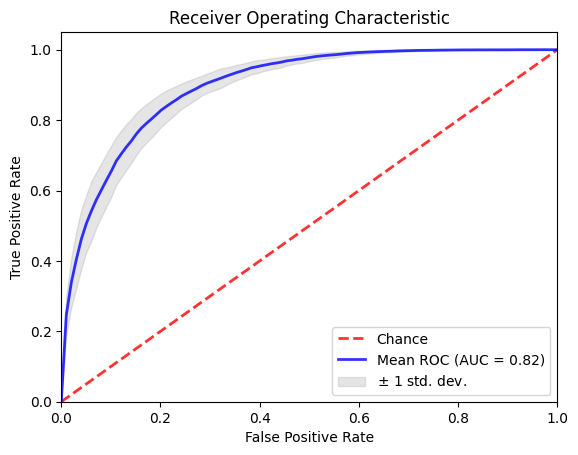

In [55]:
# Assuming that both train_features and train_features_facial are numpy arrays
min_samples = min(train_features.shape[0], train_features_facial.shape[0])
train_features = train_features[:min_samples]
train_features_facial = train_features_facial[:min_samples]
train_labels = train_labels[:min_samples]

train_features = np.expand_dims(train_features, axis=-1)
train_features_facial = np.expand_dims(train_features_facial, axis=-1)

eeg_feature_length = train_features.shape[1]
facial_feature_length = train_features_facial.shape[1]

def build_model():
    input_eeg = Input(shape=(eeg_feature_length, 1))
    eeg_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_eeg)
    eeg_pool = MaxPooling1D(pool_size=2)(eeg_conv)
    eeg_flat = Flatten()(eeg_pool)

    input_facial = Input(shape=(facial_feature_length, 1))
    facial_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_facial)
    facial_pool = MaxPooling1D(pool_size=2)(facial_conv)
    facial_flat = Flatten()(facial_pool)

    merged = concatenate([eeg_flat, facial_flat])
    hidden = Dense(50, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(hidden)

    model = Model(inputs=[input_eeg, input_facial], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=5)
accuracies = []
precisions = []
recalls = []
f1s = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

all_true_labels = []
all_pred_labels = []

for train_index, val_index in kf.split(train_features):
    train_features_fold = train_features[train_index]
    train_features_facial_fold = train_features_facial[train_index]
    train_labels_fold = train_labels[train_index]

    val_features_fold = train_features[val_index]
    val_features_facial_fold = train_features_facial[val_index]
    val_labels_fold = train_labels[val_index]

    model = build_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit([train_features_fold, train_features_facial_fold], train_labels_fold, 
              epochs=300, batch_size=64, 
              validation_data=([val_features_fold, val_features_facial_fold], val_labels_fold), 
              callbacks=[early_stopping])
    
    
    val_predictions = model.predict([val_features_fold, val_features_facial_fold])
    val_predictions_binary = (val_predictions > 0.5).astype(int).flatten()
    
    
    acc = accuracy_score(val_labels_fold, val_predictions_binary)
    precision = precision_score(val_labels_fold, val_predictions_binary)
    recall = recall_score(val_labels_fold, val_predictions_binary)
    f1 = f1_score(val_labels_fold, val_predictions_binary)
    auc = roc_auc_score(val_labels_fold, val_predictions)
    
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    auc_scores.append(auc)
    
    all_true_labels.extend(val_labels_fold)
    all_pred_labels.extend(val_predictions_binary)
    
    
    fpr, tpr, _ = roc_curve(val_labels_fold, val_predictions)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0


print(f"Mean Accuracy: {np.mean(accuracies)}")
print(f"Mean Precision: {np.mean(precisions)}")
print(f"Mean Recall: {np.mean(recalls)}")
print(f"Mean F1 Score: {np.mean(f1s)}")
print(f"Mean AUC: {np.mean(auc_scores)}")


print("\nClassification Report:")
print(classification_report(all_true_labels, all_pred_labels))


plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(all_true_labels, all_pred_labels)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


 ##### Logistic model training and evaluation

Logistic Regression Mean Accuracy: 0.6282578920090962
Logistic Regression Mean Precision: 0.6169222960658164
Logistic Regression Mean Recall: 0.6778662837652841
Logistic Regression Mean F1 Score: 0.6451707480169059
Logistic Regression Mean AUC: 0.6819632115603446

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61     17223
           1       0.62      0.68      0.65     17153

    accuracy                           0.63     34376
   macro avg       0.63      0.63      0.63     34376
weighted avg       0.63      0.63      0.63     34376


Logistic Regression Confusion Matrix:
[[ 9982  7241]
 [ 5538 11615]]


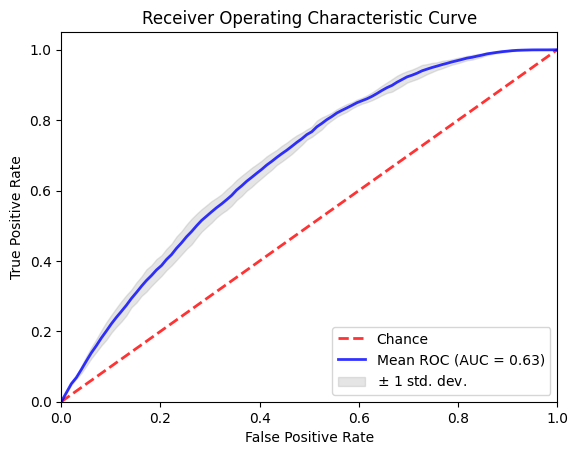

In [65]:
# data normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(train_features)
y = train_labels

kf = KFold(n_splits=5)
accuracies = []
precisions = []
recalls = []
f1s = []
auc_scores = []
all_true_labels = []
all_pred_labels = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    val_pred = log_reg.predict(X_val)
    val_pred_proba = log_reg.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred)
    recall = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    auc_score = roc_auc_score(y_val, val_pred_proba)

    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    auc_scores.append(auc_score)

    all_true_labels.extend(y_val)
    all_pred_labels.extend(val_pred)

    fpr, tpr, _ = roc_curve(y_val, val_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

print(f"Logistic Regression Mean Accuracy: {np.mean(accuracies)}")
print(f"Logistic Regression Mean Precision: {np.mean(precisions)}")
print(f"Logistic Regression Mean Recall: {np.mean(recalls)}")
print(f"Logistic Regression Mean F1 Score: {np.mean(f1s)}")
print(f"Logistic Regression Mean AUC: {np.mean(auc_scores)}")
print("\nLogistic Regression Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(all_true_labels, all_pred_labels))


plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(all_true_labels, all_pred_labels)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


#### Using EGG and facial keypoints features to train CNN model

In [9]:

# Assume that both train_features and train_features_facial are numpy arrays, and make sure they have the same number of samples.
min_samples = min(train_features.shape[0], train_features_facial.shape[0])

# Resize both to match minimum sample size
train_features = train_features[:min_samples]
train_features_facial = train_features_facial[:min_samples]
train_labels = train_labels[:min_samples]  # Make sure the tags also match

# Ensure that the input is a 3D tensor
train_features = np.expand_dims(train_features, axis=-1)
train_features_facial = np.expand_dims(train_features_facial, axis=-1)

# Get feature length
eeg_feature_length = train_features.shape[1]
facial_feature_length = train_features_facial.shape[1]

# EEG Data Input
input_eeg = Input(shape=(eeg_feature_length, 1))
eeg_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_eeg)
eeg_pool = MaxPooling1D(pool_size=2)(eeg_conv)
eeg_flat = Flatten()(eeg_pool)

# Facial Feature Input
input_facial = Input(shape=(facial_feature_length, 1))
facial_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_facial)
facial_pool = MaxPooling1D(pool_size=2)(facial_conv)
facial_flat = Flatten()(facial_pool)

# Combined characteristics
merged = concatenate([eeg_flat, facial_flat])
hidden = Dense(50, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=[input_eeg, input_facial], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit([train_features, train_features_facial], train_labels, epochs=300, batch_size=32)

min_test_samples = min(test_features.shape[0], test_features_facial.shape[0])
test_features = test_features[:min_test_samples]
test_features_facial = test_features_facial[:min_test_samples]
test_labels = test_labels[:min_test_samples] 


test_features = np.expand_dims(test_features, axis=-1)
test_features_facial = np.expand_dims(test_features_facial, axis=-1)


predictions = model.predict([test_features, test_features_facial])
accuracy = accuracy_score(test_labels, (predictions > 0.5).astype(int))




Epoch 1/300
1075/1075 [==============================] - 7s 6ms/step - loss: 0.6346 - accuracy: 0.6183
Epoch 2/300
1075/1075 [==============================] - 7s 7ms/step - loss: 0.5517 - accuracy: 0.7123
Epoch 3/300
1075/1075 [==============================] - 7s 6ms/step - loss: 0.5255 - accuracy: 0.7313
Epoch 4/300
1075/1075 [==============================] - 6s 6ms/step - loss: 0.5100 - accuracy: 0.7435
Epoch 5/300
1075/1075 [==============================] - 7s 7ms/step - loss: 0.4986 - accuracy: 0.7490
Epoch 6/300
1075/1075 [==============================] - 9s 8ms/step - loss: 0.4854 - accuracy: 0.7603
Epoch 7/300
1075/1075 [==============================] - 8s 7ms/step - loss: 0.4733 - accuracy: 0.7684
Epoch 8/300
1075/1075 [==============================] - 8s 7ms/step - loss: 0.4649 - accuracy: 0.7737
Epoch 9/300
1075/1075 [==============================] - 9s 8ms/step - loss: 0.4579 - accuracy: 0.7779
Epoch 10/300
1075/1075 [==============================] - 8s 7ms/step - l

Accuracy: 0.8328149300155521
Precision: 0.8452959562318058
Recall: 0.8328149300155521
F1 Score: 0.8363863433187328
              precision    recall  f1-score   support

     Class 0       0.91      0.84      0.88      9869
     Class 1       0.69      0.82      0.75      4277

    accuracy                           0.83     14146
   macro avg       0.80      0.83      0.81     14146
weighted avg       0.85      0.83      0.84     14146

ROC-AUC Score: 0.9066109262576603


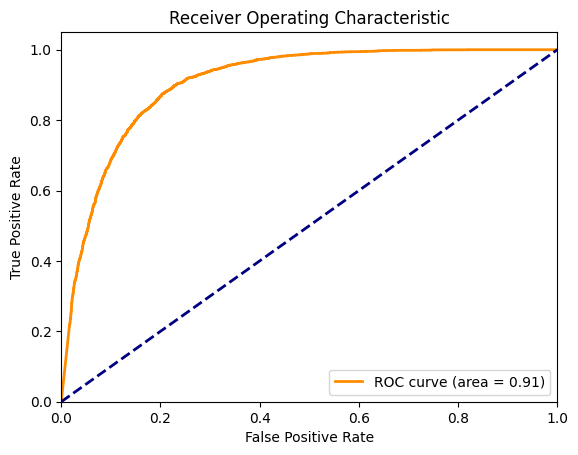

Confusion Matrix:
[[8293 1576]
 [ 789 3488]]


In [11]:
predicted_classes = (predictions > 0.5).astype(int)
accuracy = accuracy_score(test_labels, predicted_classes)
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print(classification_report(test_labels, predicted_classes, target_names=['Class 0', 'Class 1']))


if len(np.unique(test_labels)) == 2:
    roc_auc = roc_auc_score(test_labels, predictions.flatten())
    print(f"ROC-AUC Score: {roc_auc}")

    
    fpr, tpr, _ = roc_curve(test_labels, predictions.flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# 打印混淆矩阵
cm = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:")
print(cm)

Epoch 1/300
860/860 [==============================] - 3s 3ms/step - loss: 0.6313 - accuracy: 0.6264 - val_loss: 0.5930 - val_accuracy: 0.6723
Epoch 2/300
860/860 [==============================] - 2s 3ms/step - loss: 0.5739 - accuracy: 0.6839 - val_loss: 0.5616 - val_accuracy: 0.7007
Epoch 3/300
860/860 [==============================] - 3s 3ms/step - loss: 0.5474 - accuracy: 0.7104 - val_loss: 0.5491 - val_accuracy: 0.7090
Epoch 4/300
860/860 [==============================] - 2s 3ms/step - loss: 0.5331 - accuracy: 0.7235 - val_loss: 0.5372 - val_accuracy: 0.7291
Epoch 5/300
860/860 [==============================] - 3s 3ms/step - loss: 0.5220 - accuracy: 0.7313 - val_loss: 0.5376 - val_accuracy: 0.7167
Epoch 6/300
860/860 [==============================] - 3s 3ms/step - loss: 0.5133 - accuracy: 0.7375 - val_loss: 0.5288 - val_accuracy: 0.7193
Epoch 7/300
860/860 [==============================] - 2s 3ms/step - loss: 0.5046 - accuracy: 0.7440 - val_loss: 0.5323 - val_accuracy: 0.7341

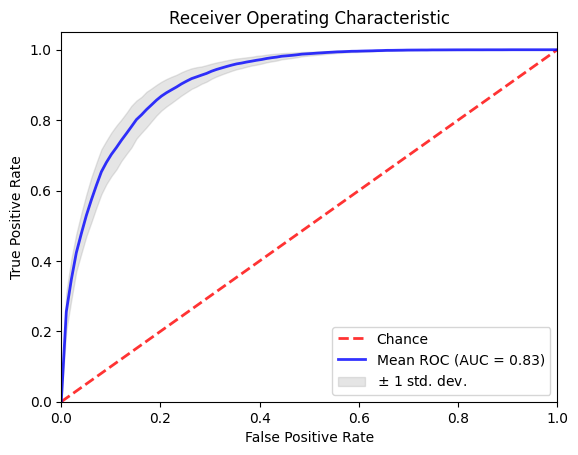

In [67]:




min_samples = min(train_features.shape[0], train_features_facial.shape[0])
train_features = train_features[:min_samples]
train_features_facial = train_features_facial[:min_samples]
train_labels = train_labels[:min_samples]

train_features = np.expand_dims(train_features, axis=-1)
train_features_facial = np.expand_dims(train_features_facial, axis=-1)

eeg_feature_length = train_features.shape[1]
facial_feature_length = train_features_facial.shape[1]

def build_multi_modal_model():
    input_eeg = Input(shape=(eeg_feature_length, 1))
    eeg_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_eeg)
    eeg_pool = MaxPooling1D(pool_size=2)(eeg_conv)
    eeg_flat = Flatten()(eeg_pool)

    input_facial = Input(shape=(facial_feature_length, 1))
    facial_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_facial)
    facial_pool = MaxPooling1D(pool_size=2)(facial_conv)
    facial_flat = Flatten()(facial_pool)

    merged = concatenate([eeg_flat, facial_flat])
    hidden = Dense(50, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(hidden)

    model = Model(inputs=[input_eeg, input_facial], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=5)
accuracies = []
precisions = []
recalls = []
f1s = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

all_true_labels = []
all_pred_labels = []

for train_index, val_index in kf.split(train_features):
    train_features_fold = train_features[train_index]
    train_features_facial_fold = train_features_facial[train_index]
    train_labels_fold = train_labels[train_index]

    val_features_fold = train_features[val_index]
    val_features_facial_fold = train_features_facial[val_index]
    val_labels_fold = train_labels[val_index]

    model = build_multi_modal_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit([train_features_fold, train_features_facial_fold], train_labels_fold, 
              epochs=300, batch_size=32, 
              validation_data=([val_features_fold, val_features_facial_fold], val_labels_fold), 
              callbacks=[early_stopping])
    
 
    val_predictions = model.predict([val_features_fold, val_features_facial_fold])
    val_predictions_binary = (val_predictions > 0.5).astype(int).flatten()
    
    
    acc = accuracy_score(val_labels_fold, val_predictions_binary)
    precision = precision_score(val_labels_fold, val_predictions_binary)
    recall = recall_score(val_labels_fold, val_predictions_binary)
    f1 = f1_score(val_labels_fold, val_predictions_binary)
    auc = roc_auc_score(val_labels_fold, val_predictions)
    
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    auc_scores.append(auc)
    
    all_true_labels.extend(val_labels_fold)
    all_pred_labels.extend(val_predictions_binary)
    
  
    fpr, tpr, _ = roc_curve(val_labels_fold, val_predictions)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0


print(f"Mean Accuracy: {np.mean(accuracies)}")
print(f"Mean Precision: {np.mean(precisions)}")
print(f"Mean Recall: {np.mean(recalls)}")
print(f"Mean F1 Score: {np.mean(f1s)}")
print(f"Mean AUC: {np.mean(auc_scores)}")


print("\nClassification Report:")
print(classification_report(all_true_labels, all_pred_labels))


plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(all_true_labels, all_pred_labels)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [69]:
import numpy as np

# Average performance metrics for unimodal and multimodal CNNs
single_modal_metrics = {
    'accuracy': 0.8155107938018933,
    'precision': 0.7897126555345262,
    'recall': 0.858020332901491,
    'f1_score': 0.8223859723225717,
    'auc': 0.896667925282037
}

multi_modal_metrics = {
    'accuracy': 0.8343323454439684,
    'precision': 0.8148823536107225,
    'recall': 0.8653301202977788,
    'f1_score': 0.8392385745522655,
    'auc': 0.9119805588168278
}

# Number of Bootstrap samples simulated
n_bootstraps = 1000

# Differences in Storing Bootstrap Samples
bootstrap_differences = {key: [] for key in single_modal_metrics}


for _ in range(n_bootstraps):
    for key in single_modal_metrics:
        # Assuming that the performance metrics conform to a normal distribution, samples are generated using mean and standard deviation
        single_sample = np.random.normal(single_modal_metrics[key], 0.01, 1)
        multi_sample = np.random.normal(multi_modal_metrics[key], 0.01, 1)
        difference = multi_sample - single_sample
        bootstrap_differences[key].append(difference[0])

# Checking for normality and choosing an appropriate test
from scipy.stats import shapiro, ttest_1samp, wilcoxon

for key in bootstrap_differences:
    differences = np.array(bootstrap_differences[key])
    stat, p_value = shapiro(differences)
    print(f"{key} differences Shapiro-Wilk test: statistic = {stat}, p-value = {p_value}")

    if p_value > 0.05:
        print(f"{key} differences符合正态分布，可以使用t检验")
        t_stat, p_value_ttest = ttest_1samp(differences, 0)
        print(f"{key} t-test: t-statistic = {t_stat}, p-value = {p_value_ttest}")
    else:
        print(f"{key} differences不符合正态分布，建议使用非参数检验方法")
        w_stat, p_value_wilcoxon = wilcoxon(differences)
        print(f"{key} Wilcoxon signed-rank test: w-statistic = {w_stat}, p-value = {p_value_wilcoxon}")

    print("\n")


accuracy differences Shapiro-Wilk test: statistic = 0.998469889163971, p-value = 0.535108745098114
accuracy differences符合正态分布，可以使用t检验
accuracy t-test: t-statistic = 44.32408615995856, p-value = 3.9662174883807175e-238


precision differences Shapiro-Wilk test: statistic = 0.9983268976211548, p-value = 0.4470667541027069
precision differences符合正态分布，可以使用t检验
precision t-test: t-statistic = 55.97513461879971, p-value = 2.89446385245396e-310


recall differences Shapiro-Wilk test: statistic = 0.9987925887107849, p-value = 0.7500746846199036
recall differences符合正态分布，可以使用t检验
recall t-test: t-statistic = 16.919006614590295, p-value = 1.1744802789957081e-56


f1_score differences Shapiro-Wilk test: statistic = 0.9968466758728027, p-value = 0.04432389885187149
f1_score differences不符合正态分布，建议使用非参数检验方法
f1_score Wilcoxon signed-rank test: w-statistic = 23658.0, p-value = 8.257611833947137e-136


auc differences Shapiro-Wilk test: statistic = 0.999111533164978, p-value = 0.9242665767669678
auc differ